# 理想带阻滤波器

理想带阻滤波器是频域滤波的一种，主要是抑制距离频域中心D0、一个圆环区域的频域成分，因此可以使用理想带阻滤波器来消除频率分布在圆环上的周期噪声。

公式如下

![](doc_imgs/01.jpg)

## 算法实现

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [3]:
'''
理想带阻滤波器
input:
     M,N:频域滤波器的尺寸
     D0：带阻滤波器的截止频率
     W:带宽
output:
       H：M x N的矩阵，表示频域滤波器矩阵，数据类型为double，
'''
def freqfilter_ideal(M,N,D0,W):
    u = np.arange(-M//2,M//2,0.5)
    v = np.arange(-N//2.,N//2,0.5)
    U,V = np.meshgrid(u,v)
    D = np.sqrt(U**2 + V**2)
    print(D)
    idx = (D < (D0 - W / 2)) | (D > (D0 + W / 2))
    H = np.zeros_like(D)
    H[idx] = 1
    H[~idx] = 0
    return H

In [4]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [13]:
'''
图像理想低通滤波
'''
def freqfilter_ideal_lp(src,D0):
    src_f = src.astype('float64') / 255.0
    # 傅立叶变换 
    img_fft = np.fft.fft2(src_f)
    img_fftshift = np.fft.fftshift(img_fft)
    
    # 进行理想低通滤波
    idx = (np.abs(img_fftshift) < D0)
#     print(np.abs(img_fftshift))
    dst_fftshift = np.zeros_like(img_fftshift)
    dst_fftshift[~idx] = img_fftshift[~idx]
#     dst_fftshift[~idx] = 0

    dst_ifftshift = np.fft.ifftshift(dst_fftshift)
    dst = np.fft.ifft2(dst_ifftshift)
    dst = np.abs(dst)
    dst = dst * 255
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    
    return dst.astype('uint8')
    

In [14]:
src = cv2.cvtColor(cv2.imread('../../datas/f3.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [15]:
rows,cols = gray.shape
noise = noise_gaussian(rows,cols,a=0,b=0.1)
src_noise = np.zeros(src.shape,dtype=np.float64)
src_noise[:,:,0] = np.float64(src[:,:,0]) + noise * 255
src_noise[:,:,1] = np.float64(src[:,:,1]) + noise * 255
src_noise[:,:,2] = np.float64(src[:,:,2]) + noise * 255

src_noise[src_noise < 0] = 0
src_noise[src_noise > 255] = 255
src_noise = src_noise.astype(np.uint8)

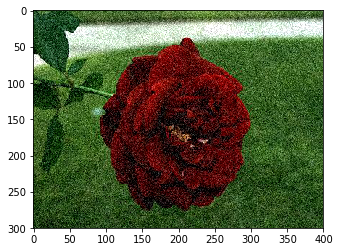

In [16]:
plt.imshow(src_noise)

In [17]:
dstr = freqfilter_ideal_lp(src_noise[:,:,0],70)
dstg = freqfilter_ideal_lp(src_noise[:,:,1],70)
dstb = freqfilter_ideal_lp(src_noise[:,:,2],70)
# dst = freqfilter_ideal_lp(gray,20 / 255.0)

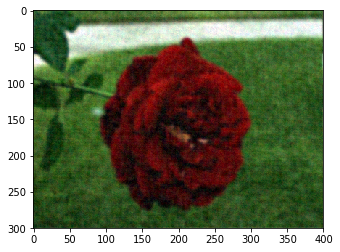

In [18]:
# plt.imshow(dst,'gray')
plt.imshow(cv2.merge([dstr,dstg,dstb]))

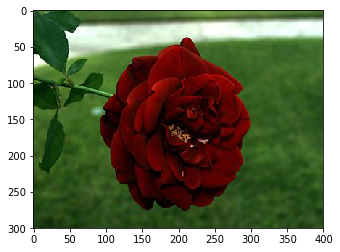

In [11]:
plt.imshow(src)

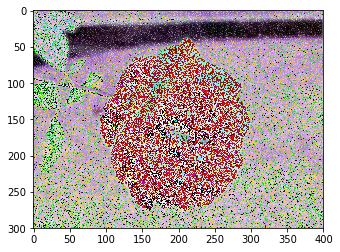

In [12]:
plt.imshow(np.abs(cv2.merge([dstr,dstg,dstb]) - src_noise))